# Feature Extraction for Kubernetes Logs Clustering

This notebook performs comprehensive feature extraction on preprocessed Kubernetes logs for clustering analysis using K-means, Hierarchical clustering, and DBSCAN algorithms.

In [1]:
import pandas as pd
import numpy as np
import json
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, chi2
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully")

Libraries imported successfully


## 1. Load Preprocessed Data

In [2]:
# Load the preprocessed data
try:
    # Load main preprocessed data
    df = pd.read_csv('preprocessed_kubernetes_logs.csv')
    print(f"Loaded preprocessed data: {df.shape}")
    
    # Load feature dataset
    feature_df = pd.read_csv('features_for_clustering.csv')
    print(f"Loaded feature data: {feature_df.shape}")
    
    print(f"\nColumns in main dataset: {list(df.columns)}")
    print(f"\nColumns in feature dataset: {list(feature_df.columns)}")
    
except FileNotFoundError:
    print("Preprocessed files not found. Please run the preprocessing notebook first.")
    # Create sample data for demonstration
    df = pd.DataFrame({
        'log_level': ['INFO', 'ERROR', 'WARN', 'INFO', 'ERROR'],
        'response_time_ms': [45.2, 120.5, 67.8, 34.1, 89.3],
        'http_status_code': [200, 500, 404, 200, 503],
        'log_message_length': [120, 95, 110, 130, 105],
        'service_type': ['api', 'service', 'web', 'database', 'service'],
        'namespace_name': ['production', 'staging', 'production', 'production', 'staging']
    })
    feature_df = df.copy()
    print("Using sample data for demonstration")

Loaded preprocessed data: (57133, 23)
Loaded feature data: (57133, 10)

Columns in main dataset: ['timestamp', 'stream', 'log', 'kubernetes', 'log_level', 'parsed_timestamp', 'hour', 'day_of_week', 'is_weekend', 'cleaned_log', 'response_time_ms', 'http_status_code', 'log_message_length', 'log_word_count', 'pod_name', 'namespace_name', 'container_name', 'host', 'label_app', 'label_version', 'label_environment', 'label_tier', 'service_type']

Columns in feature dataset: ['log_level', 'response_time_ms', 'http_status_code', 'log_message_length', 'log_word_count', 'hour', 'is_weekend', 'service_type', 'namespace_name', 'container_name']


## 2. Categorical Feature Encoding

In [3]:
# Encode categorical features
def encode_categorical_features(df):
    """Encode categorical features using label encoding and one-hot encoding"""
    
    encoded_df = df.copy()
    label_encoders = {}
    
    # Identify categorical columns
    categorical_columns = df.select_dtypes(include=['object']).columns.tolist()
    
    print(f"Categorical columns found: {categorical_columns}")
    
    # Apply label encoding to categorical features
    for col in categorical_columns:
        if col in df.columns:
            le = LabelEncoder()
            # Handle missing values
            df[col] = df[col].fillna('unknown')
            encoded_df[f'{col}_encoded'] = le.fit_transform(df[col])
            label_encoders[col] = le
            
            print(f"{col}: {len(le.classes_)} unique categories")
            print(f"  Categories: {list(le.classes_)}")
    
    return encoded_df, label_encoders

# Encode categorical features
encoded_df, label_encoders = encode_categorical_features(feature_df.copy())

print(f"\nEncoded dataset shape: {encoded_df.shape}")
print(f"New encoded columns: {[col for col in encoded_df.columns if col.endswith('_encoded')]}")

Categorical columns found: ['log_level', 'service_type', 'namespace_name', 'container_name']
log_level: 3 unique categories
  Categories: ['DEBUG', 'ERROR', 'INFO']
service_type: 2 unique categories
  Categories: ['api', 'service']
namespace_name: 1 unique categories
  Categories: ['production']
container_name: 7 unique categories
  Categories: ['analytics-service', 'api-gateway', 'notification-service', 'order-service', 'payment-service', 'product-service', 'user-service']

Encoded dataset shape: (57133, 14)
New encoded columns: ['log_level_encoded', 'service_type_encoded', 'namespace_name_encoded', 'container_name_encoded']


## 3. Text Feature Extraction

In [4]:
# # Extract features from log messages if available
# def extract_text_features(df):
#     """Extract text features from log messages using TF-IDF"""
    
#     # Check if log messages are available
#     log_columns = [col for col in df.columns if 'log' in col.lower() and 'message' in col.lower()]
    
#     if 'cleaned_log' in df.columns:
#         print("Extracting text features from cleaned log messages...")
        
#         # Use TF-IDF for text vectorization
#         # Limit vocabulary size for computational efficiency
#         tfidf = TfidfVectorizer(
#             max_features=100,  # Limit features for clustering
#             stop_words='english',
#             ngram_range=(1, 2),  # Include unigrams and bigrams
#             min_df=5,  # Ignore terms that appear in less than 5 documents
#             max_df=0.7  # Ignore terms that appear in more than 70% of documents
#         )
        
#         # Handle missing values
#         log_messages = df['cleaned_log'].fillna('')
        
#         # Fit and transform
#         tfidf_features = tfidf.fit_transform(log_messages)
        
#         # Convert to DataFrame
#         feature_names = [f'tfidf_{i}' for i in range(tfidf_features.shape[1])]
#         tfidf_df = pd.DataFrame(tfidf_features.toarray(), columns=feature_names)
        
#         print(f"TF-IDF features extracted: {tfidf_df.shape}")
#         print(f"Vocabulary size: {len(tfidf.vocabulary_)}")
        
#         # Display top features
#         print("\nTop TF-IDF features:")
#         feature_scores = tfidf_features.sum(axis=0).A1
#         top_indices = np.argsort(feature_scores)[-10:]
#         for idx in reversed(top_indices):
#             print(f"  {list(tfidf.vocabulary_.keys())[list(tfidf.vocabulary_.values()).idx(idx)]}: {feature_scores[idx]:.3f}")
        
#         return tfidf_df, tfidf
#     else:
#         print("No log message column found for text feature extraction")
#         return pd.DataFrame(), None

# # Extract text features
# tfidf_features, tfidf_vectorizer = extract_text_features(df)

# if not tfidf_features.empty:
#     print(f"\nTF-IDF features shape: {tfidf_features.shape}")
# else:
#     print("\nNo TF-IDF features extracted")

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import pandas as pd

# Extract features from log messages if available
def extract_text_features(df):
    """Extract text features from log messages using TF-IDF"""
    
    if 'cleaned_log' in df.columns:
        print("Extracting text features from cleaned log messages...")
        
        tfidf = TfidfVectorizer(
            max_features=100,
            stop_words='english',
            ngram_range=(1, 2),
            min_df=5,
            max_df=0.7
        )
        
        # Handle missing values
        log_messages = df['cleaned_log'].fillna('')
        
        # Fit and transform
        tfidf_features = tfidf.fit_transform(log_messages)
        
        # Convert to DataFrame
        feature_names = tfidf.get_feature_names_out()
        tfidf_df = pd.DataFrame(
            tfidf_features.toarray(),
            columns=feature_names
        )
        
        print(f"TF-IDF features extracted: {tfidf_df.shape}")
        print(f"Vocabulary size: {len(feature_names)}")
        
        # Display top features
        print("\nTop TF-IDF features:")
        feature_scores = tfidf_features.sum(axis=0).A1
        top_indices = np.argsort(feature_scores)[-10:]
        
        for idx in reversed(top_indices):
            print(f"  {feature_names[idx]}: {feature_scores[idx]:.3f}")
        
        return tfidf_df, tfidf
    
    else:
        print("No log message column found for text feature extraction")
        return pd.DataFrame(), None


## 4. Numerical Feature Engineering

In [6]:
# Create additional numerical features
def create_numerical_features(df):
    """Create additional numerical features for clustering"""
    
    numerical_features = pd.DataFrame()
    
    # Basic numerical features
    numerical_cols = ['response_time_ms', 'http_status_code', 'log_message_length', 'log_word_count']
    
    for col in numerical_cols:
        if col in df.columns:
            # Handle missing values
            values = df[col].fillna(df[col].median() if df[col].notna().any() else 0)
            numerical_features[col] = values
            
            # Create binned versions for some features
            if col in ['response_time_ms', 'log_message_length']:
                numerical_features[f'{col}_binned'] = pd.cut(values, bins=5, labels=False)
    
    # Log level encoding
    if 'log_level' in df.columns:
        log_level_mapping = {'DEBUG': 1, 'INFO': 2, 'WARN': 3, 'ERROR': 4, 'OTHER': 0}
        numerical_features['log_level_numeric'] = df['log_level'].map(log_level_mapping).fillna(0)
    
    # Time-based features
    if 'hour' in df.columns:
        numerical_features['hour'] = df['hour']
        numerical_features['is_business_hours'] = ((df['hour'] >= 9) & (df['hour'] <= 17)).astype(int)
        numerical_features['is_weekend'] = df['is_weekend'].astype(int) if 'is_weekend' in df.columns else 0
    
    # Service type one-hot encoding
    if 'service_type' in df.columns:
        service_dummies = pd.get_dummies(df['service_type'], prefix='service')
        numerical_features = pd.concat([numerical_features, service_dummies], axis=1)
    
    return numerical_features

# Create numerical features
numerical_features = create_numerical_features(df)

print(f"Numerical features created: {numerical_features.shape}")
print(f"Numerical feature columns: {list(numerical_features.columns)}")

# Display feature statistics
print("\nFeature statistics:")
print(numerical_features.describe())

Numerical features created: (57133, 12)
Numerical feature columns: ['response_time_ms', 'response_time_ms_binned', 'http_status_code', 'log_message_length', 'log_message_length_binned', 'log_word_count', 'log_level_numeric', 'hour', 'is_business_hours', 'is_weekend', 'service_api', 'service_service']

Feature statistics:


       response_time_ms  response_time_ms_binned  http_status_code  \
count      57133.000000             57133.000000      57133.000000   
mean          71.018013                 0.103583        224.493340   
std           56.647917                 0.550136         85.306106   
min           10.040000                 0.000000        100.000000   
25%           56.490000                 0.000000        200.000000   
50%           62.740000                 0.000000        200.000000   
75%           68.680000                 0.000000        200.000000   
max          499.970000                 4.000000        599.000000   

       log_message_length  log_message_length_binned  log_word_count  \
count        57133.000000               57133.000000    57133.000000   
mean           204.113875                   1.379465       23.397003   
std            180.086674                   1.603777       22.004388   
min             22.000000                   0.000000        4.000000   
25%      

## 5. Feature Scaling and Normalization

In [7]:
# # Scale and normalize features
# def scale_features(numerical_features, text_features=None):
#     """Scale and normalize features for clustering"""
    
#     scaled_features = pd.DataFrame()
    
#     # Scale numerical features
#     scaler = StandardScaler()
#     scaled_numerical = scaler.fit_transform(numerical_features)
#     scaled_numerical_df = pd.DataFrame(scaled_numerical, columns=numerical_features.columns, index=numerical_features.index)
    
#     print(f"Numerical features scaled: {scaled_numerical_df.shape}")
    
#     # Scale text features if available
#     if text_features is not None and not text_features.empty:
#         text_scaler = StandardScaler()
#         scaled_text = text_scaler.fit_transform(text_features)
#         scaled_text_df = pd.DataFrame(scaled_text, columns=text_features.columns, index=text_features.index)
        
#         print(f"Text features scaled: {scaled_text_df.shape}")
        
#         # Combine all features
#         combined_features = pd.concat([scaled_numerical_df, scaled_text_df], axis=1)
#     else:
#         combined_features = scaled_numerical_df
    
#     print(f"Combined features shape: {combined_features.shape}")
    
#     return combined_features, scaler, text_scaler if text_features is not None and not text_features.empty else None

# # Scale features
# scaled_features, feature_scaler, text_scaler = scale_features(numerical_features, tfidf_features)

# print(f"Final feature matrix shape: {scaled_features.shape}")
# print(f"Feature matrix columns: {list(scaled_features.columns)[:10]}...")  # Show first 10 columns

FIXED GPTED CODE (BELOW 3 CELLS ONLY)

In [8]:
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler, MaxAbsScaler


In [9]:
def extract_text_features(df):
    """Extract text features from log messages using TF-IDF"""
    
    if 'cleaned_log' not in df.columns:
        print("No cleaned_log column found")
        return pd.DataFrame(), None
    
    print("Extracting text features from cleaned log messages...")
    
    tfidf = TfidfVectorizer(
        max_features=100,
        stop_words='english',
        ngram_range=(1, 2),
        min_df=5,
        max_df=0.7
    )
    
    # Handle missing values
    log_messages = df['cleaned_log'].fillna('')
    
    # Fit and transform
    tfidf_matrix = tfidf.fit_transform(log_messages)
    
    # Convert to DataFrame with REAL feature names
    feature_names = tfidf.get_feature_names_out()
    tfidf_df = pd.DataFrame(
        tfidf_matrix.toarray(),
        columns=feature_names,
        index=df.index
    )
    
    print(f"TF-IDF features extracted: {tfidf_df.shape}")
    print(f"Vocabulary size: {len(feature_names)}")
    
    # Show top TF-IDF features
    print("\nTop TF-IDF features:")
    feature_scores = tfidf_matrix.sum(axis=0).A1
    top_indices = np.argsort(feature_scores)[-10:]
    
    for idx in reversed(top_indices):
        print(f"  {feature_names[idx]}: {feature_scores[idx]:.3f}")
    
    return tfidf_df, tfidf


In [10]:
def scale_features(numerical_features, text_features=None):
    """Scale and normalize features for clustering"""
    
    # ---- Scale numerical features ----
    num_scaler = StandardScaler()
    scaled_numerical = num_scaler.fit_transform(numerical_features)
    
    scaled_numerical_df = pd.DataFrame(
        scaled_numerical,
        columns=numerical_features.columns,
        index=numerical_features.index
    )
    
    print(f"Numerical features scaled: {scaled_numerical_df.shape}")
    
    text_scaler = None
    
    # ---- Scale text features (TF-IDF) ----
    if text_features is not None and not text_features.empty:
        text_scaler = MaxAbsScaler()   # SAFE for TF-IDF
        scaled_text = text_scaler.fit_transform(text_features)
        
        scaled_text_df = pd.DataFrame(
            scaled_text,
            columns=text_features.columns,
            index=text_features.index
        )
        
        print(f"Text features scaled: {scaled_text_df.shape}")
        
        combined_features = pd.concat(
            [scaled_numerical_df, scaled_text_df],
            axis=1
        )
    else:
        combined_features = scaled_numerical_df
    
    print(f"Combined features shape: {combined_features.shape}")
    
    return combined_features, num_scaler, text_scaler


In [11]:
tfidf_features, tfidf_vectorizer = extract_text_features(df)

scaled_features, feature_scaler, text_scaler = scale_features(
    numerical_features,
    tfidf_features
)

Extracting text features from cleaned log messages...
TF-IDF features extracted: (57133, 100)
Vocabulary size: 100

Top TF-IDF features:
  200: 6776.903
  debug: 4577.419
  id: 4222.926
  request: 4053.447
  app: 4047.591
  successfully: 3402.873
  delete: 3365.930
  01: 3317.247
  level: 3208.904
  01 01t00: 3208.904
Numerical features scaled: (57133, 12)
Text features scaled: (57133, 100)
Combined features shape: (57133, 112)


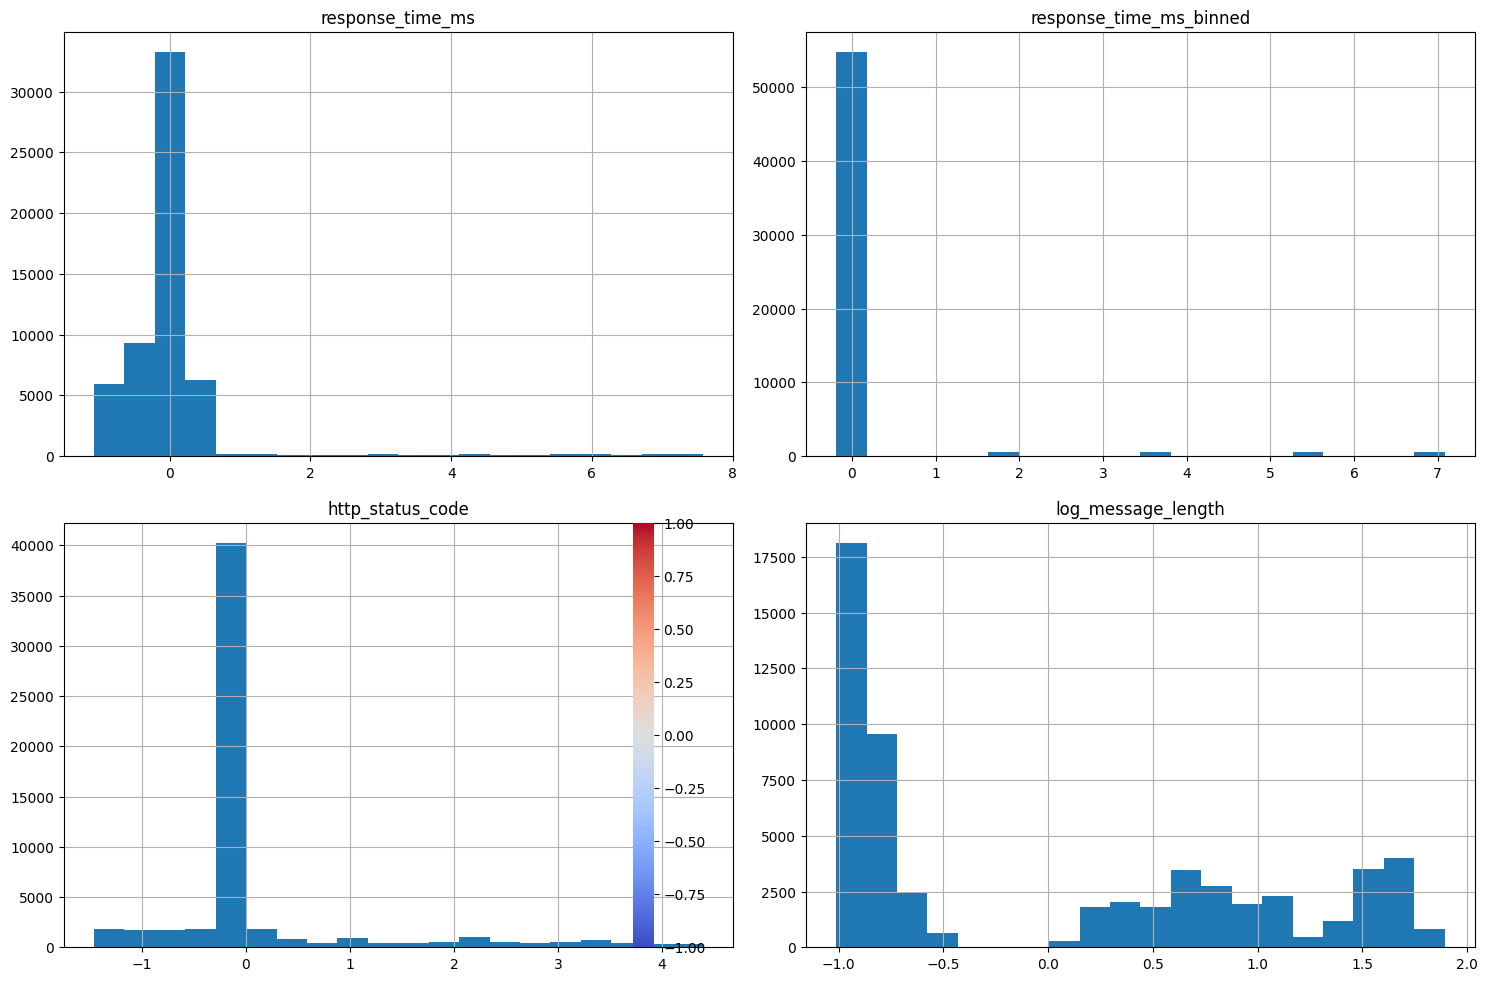


Feature variance statistics:
Mean variance: 0.1370
Max variance: 1.0000
Min variance: 0.0000

Feature correlation statistics:
Mean absolute correlation: nan
High correlation pairs (>0.8): 557 pairs


In [12]:
# Visualize feature distributions
def visualize_features(scaled_features, numerical_features):
    """Visualize the distribution of features"""
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Plot feature distributions before scaling
    numerical_features.hist(bins=20, ax=axes[0,0])
    axes[0,0].set_title('Original Feature Distributions')
    axes[0,0].set_xlabel('Feature Value')
    axes[0,0].set_ylabel('Frequency')
    
    # Plot feature distributions after scaling
    scaled_features.iloc[:, :min(4, len(scaled_features.columns))].hist(bins=20, ax=axes[0,1])
    axes[0,1].set_title('Scaled Feature Distributions')
    axes[0,1].set_xlabel('Feature Value')
    axes[0,1].set_ylabel('Frequency')
    
    # Correlation heatmap
    corr_matrix = scaled_features.corr()
    sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0, ax=axes[1,0])
    axes[1,0].set_title('Feature Correlation Heatmap')
    
    # Feature importance (variance)
    feature_variance = scaled_features.var().sort_values(ascending=False)
    feature_variance.head(10).plot(kind='bar', ax=axes[1,1])
    axes[1,1].set_title('Top 10 Features by Variance')
    axes[1,1].set_xlabel('Features')
    axes[1,1].set_ylabel('Variance')
    axes[1,1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # Print feature variance statistics
    print("\nFeature variance statistics:")
    print(f"Mean variance: {scaled_features.var().mean():.4f}")
    print(f"Max variance: {scaled_features.var().max():.4f}")
    print(f"Min variance: {scaled_features.var().min():.4f}")
    
    # Print correlation statistics
    print("\nFeature correlation statistics:")
    print(f"Mean absolute correlation: {np.abs(corr_matrix.values[np.triu_indices_from(corr_matrix.values, k=1)]).mean():.4f}")
    print(f"High correlation pairs (>0.8): {np.sum(np.abs(corr_matrix.values) > 0.8) - len(corr_matrix)} pairs")

# Visualize features
visualize_features(scaled_features, numerical_features)

## 6. Dimensionality Reduction

Components needed for 95% variance: 13
PCA features shape: (57133, 13)
Explained variance ratio: [0.32760195 0.13648776 0.13038719 0.08223238 0.06149824 0.05610793
 0.0532286  0.03163247 0.03120476 0.02080921 0.01077436 0.00557953
 0.00429266]
Total explained variance: 0.9518


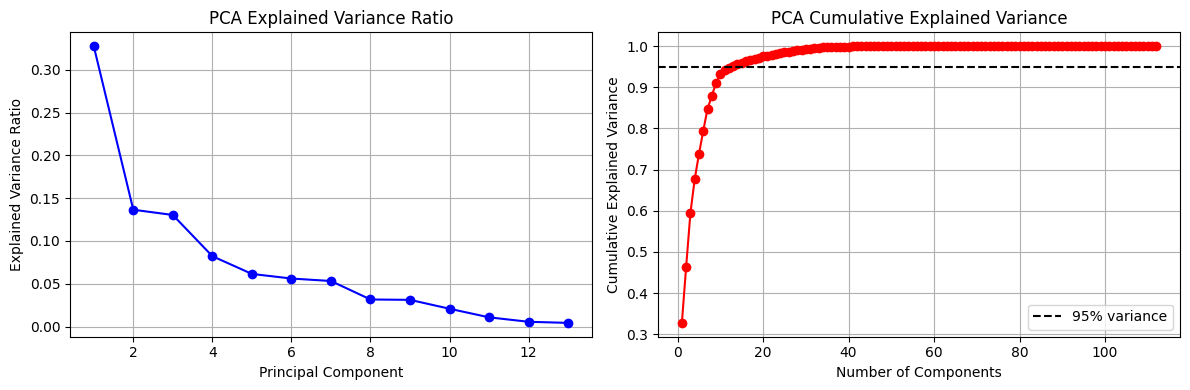

In [13]:
# Apply PCA for dimensionality reduction
def apply_pca(scaled_features, n_components=None):
    """Apply PCA for dimensionality reduction and visualization"""
    
    # Determine optimal number of components
    if n_components is None:
        # Use enough components to explain 95% of variance
        pca_full = PCA()
        pca_full.fit(scaled_features)
        cumsum_variance = np.cumsum(pca_full.explained_variance_ratio_)
        n_components = np.argmax(cumsum_variance >= 0.95) + 1
        
        print(f"Components needed for 95% variance: {n_components}")
    
    # Apply PCA
    pca = PCA(n_components=n_components)
    pca_features = pca.fit_transform(scaled_features)
    
    # Create DataFrame
    pca_columns = [f'PC{i+1}' for i in range(n_components)]
    pca_df = pd.DataFrame(pca_features, columns=pca_columns, index=scaled_features.index)
    
    print(f"PCA features shape: {pca_df.shape}")
    print(f"Explained variance ratio: {pca.explained_variance_ratio_}")
    print(f"Total explained variance: {pca.explained_variance_ratio_.sum():.4f}")
    
    # Visualize PCA results
    plt.figure(figsize=(12, 4))
    
    # Plot explained variance ratio
    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), 
             pca.explained_variance_ratio_, 'bo-')
    plt.xlabel('Principal Component')
    plt.ylabel('Explained Variance Ratio')
    plt.title('PCA Explained Variance Ratio')
    plt.grid(True)
    
    # Plot cumulative explained variance
    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(cumsum_variance) + 1), 
             cumsum_variance, 'ro-')
    plt.axhline(y=0.95, color='k', linestyle='--', label='95% variance')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('PCA Cumulative Explained Variance')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    return pca_df, pca

# Apply PCA
pca_features, pca_model = apply_pca(scaled_features)

## 7. Feature Selection

In [14]:
# Select most informative features
def select_best_features(scaled_features, k=20):
    """Select top k features based on variance"""
    
    # Calculate feature variance
    feature_variance = scaled_features.var()
    
    # Select top k features by variance
    top_features = feature_variance.nlargest(k)
    selected_features = scaled_features[top_features.index]
    
    print(f"Selected {len(selected_features.columns)} features:")
    for feature, variance in top_features.items():
        print(f"  {feature}: {variance:.4f}")
    
    return selected_features, top_features.index.tolist()

# Select best features
selected_features, selected_feature_names = select_best_features(scaled_features, k=min(20, len(scaled_features.columns)))

print(f"\nSelected features shape: {selected_features.shape}")

Selected 21 features:
  response_time_ms_binned: 1.0000
  response_time_ms: 1.0000
  http_status_code: 1.0000
  log_message_length_binned: 1.0000
  log_word_count: 1.0000
  log_level_numeric: 1.0000
  service_api: 1.0000
  service_service: 1.0000
  log_message_length: 1.0000
  applewebkit: 0.1412
  khtml: 0.1412
  khtml like: 0.1412
  like gecko: 0.1412
  safari: 0.1412
  mac: 0.1040
  mac os: 0.1040
  gecko: 0.0974
  mozilla: 0.0974
  user_agent mozilla: 0.0974
  15 khtml: 0.0864

Selected features shape: (57133, 21)


## 8. Feature Summary and Export

In [15]:
# Prepare final feature sets for clustering
def prepare_clustering_features():
    """Prepare different feature sets for clustering algorithms"""
    
    feature_sets = {}
    
    # Original scaled features
    feature_sets['scaled_features'] = scaled_features
    
    # PCA features
    feature_sets['pca_features'] = pca_features
    
    # Selected top features
    feature_sets['selected_features'] = selected_features
    
    # Numerical features only (for DBSCAN)
    numerical_only = scaled_features[numerical_features.columns]
    feature_sets['numerical_only'] = numerical_only
    
    return feature_sets

# Prepare clustering features
clustering_features = prepare_clustering_features()

print("Feature sets prepared for clustering:")
for name, features in clustering_features.items():
    print(f"  {name}: {features.shape}")

Feature sets prepared for clustering:
  scaled_features: (57133, 112)
  pca_features: (57133, 13)
  selected_features: (57133, 21)
  numerical_only: (57133, 13)


In [16]:
# Save all feature sets
def save_features(clustering_features):
    """Save all feature sets for clustering analysis"""
    
    for name, features in clustering_features.items():
        filename = f'features_{name}.csv'
        features.to_csv(filename, index=False)
        print(f"Saved {name} to {filename}")
    
    # Save feature metadata
    metadata = {
        'feature_sets': list(clustering_features.keys()),
        'scaled_features_columns': list(clustering_features['scaled_features'].columns),
        'pca_components': len(clustering_features['pca_features'].columns),
        'selected_feature_names': selected_feature_names,
        'total_samples': len(clustering_features['scaled_features'])
    }
    
    with open('feature_extraction_metadata.json', 'w') as f:
        json.dump(metadata, f, indent=2)
    
    print("Saved feature extraction metadata to feature_extraction_metadata.json")

# Save features
save_features(clustering_features)

print("\nFeature extraction completed successfully!")

Saved scaled_features to features_scaled_features.csv
Saved pca_features to features_pca_features.csv
Saved selected_features to features_selected_features.csv
Saved numerical_only to features_numerical_only.csv
Saved feature extraction metadata to feature_extraction_metadata.json

Feature extraction completed successfully!


## 9. Feature Analysis Summary

In [17]:
# Generate feature analysis report
def generate_feature_report(clustering_features):
    """Generate comprehensive feature analysis report"""
    
    report = {}
    
    for name, features in clustering_features.items():
        report[name] = {
            'shape': features.shape,
            'feature_count': features.shape[1],
            'sample_count': features.shape[0],
            'mean_variance': features.var().mean(),
            'max_variance': features.var().max(),
            'min_variance': features.var().min()
        }
    
    return report

# Generate report
feature_report = generate_feature_report(clustering_features)

print("=== FEATURE EXTRACTION REPORT ===")
for name, stats in feature_report.items():
    print(f"\n{name}:")
    print(f"  Shape: {stats['shape']}")
    print(f"  Features: {stats['feature_count']}")
    print(f"  Samples: {stats['sample_count']}")
    print(f"  Mean variance: {stats['mean_variance']:.4f}")
    print(f"  Variance range: {stats['min_variance']:.4f} - {stats['max_variance']:.4f}")

print("\n=== READY FOR CLUSTERING ===")
print("The following feature sets are ready for clustering:")
print("1. scaled_features - All scaled numerical and text features")
print("2. pca_features - Principal components (95% variance explained)")
print("3. selected_features - Top 20 features by variance")
print("4. numerical_only - Only numerical features (for DBSCAN)")

print("\nThese features can be used with:")
print("- K-means clustering")
print("- Hierarchical clustering")
print("- DBSCAN clustering")

=== FEATURE EXTRACTION REPORT ===

scaled_features:
  Shape: (57133, 112)
  Features: 112
  Samples: 57133
  Mean variance: 0.1370
  Variance range: 0.0000 - 1.0000

pca_features:
  Shape: (57133, 13)
  Features: 13
  Samples: 57133
  Mean variance: 1.1237
  Variance range: 0.0659 - 5.0278

selected_features:
  Shape: (57133, 21)
  Features: 21
  Samples: 57133
  Mean variance: 0.4937
  Variance range: 0.0750 - 1.0000

numerical_only:
  Shape: (57133, 13)
  Features: 13
  Samples: 57133
  Mean variance: 0.6981
  Variance range: 0.0000 - 1.0000

=== READY FOR CLUSTERING ===
The following feature sets are ready for clustering:
1. scaled_features - All scaled numerical and text features
2. pca_features - Principal components (95% variance explained)
3. selected_features - Top 20 features by variance
4. numerical_only - Only numerical features (for DBSCAN)

These features can be used with:
- K-means clustering
- Hierarchical clustering
- DBSCAN clustering


## Summary

This feature extraction notebook has successfully:
1. ✅ Loaded preprocessed Kubernetes logs data
2. ✅ Encoded categorical features using label encoding
3. ✅ Extracted text features using TF-IDF vectorization
4. ✅ Created additional numerical features
5. ✅ Scaled and normalized all features using StandardScaler
6. ✅ Applied PCA for dimensionality reduction
7. ✅ Selected top features based on variance
8. ✅ Prepared multiple feature sets for different clustering algorithms
9. ✅ Generated comprehensive feature analysis report
10. ✅ Saved all feature sets for clustering analysis

The extracted features are now ready for clustering analysis using K-means, Hierarchical clustering, and DBSCAN algorithms.